<a href="https://colab.research.google.com/github/jakedorman64/internship/blob/main/Navier_Stokes_Solver_With_Periodic_Boundaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2D Navier-Stokes Solver ##

The Navier-Stokes Equations are: 
$$ \frac{d\textbf{u}}{dt} + (\textbf{u} \cdot \nabla ) \textbf{u} = - \frac{1}{\rho} \nabla p + \nu \nabla^2 \textbf{u} + \textbf{f} $$
$$ \nabla \cdot \textbf{u} = 0 $$

Where: 

*   $\rho$ is density,

*   $\textbf{u}$ is velocity,
*   $p$ is pressure, 
*   $\nu$ is kinematic viscosity,
*   $\textbf{f}$ is the sum of all external forces. 

We cannot use the standard Euler's method for numerical ODE's because this will not ensure that the second equation is satisfied. It also only gives us an equation for the velocity, and not one for the pressure.

Method of solution is presented here: 
http://hplgit.github.io/INF5620/doc/pub/main_ns.pdf

I have also used the implementation presented here for guidance: https://www.youtube.com/watch?v=BQLvNLgMTQE

We are setting force to 0. Essentially we use the following approach, with timestep $dt$: 

1.   Find an intermidiate velocity $ \textbf{u}^* $ from the first Navier-Stokes Equation using: $$ \textbf{u}^* = \textbf{u}^n  - dt (\textbf{u}^n \cdot \nabla  ) \textbf{u}^n + dt \, \nu \nabla^2 \textbf{u}^n $$
2.   Solve the following equation for pressure: $$ \nabla^2 p^{n+1}  = \frac{\rho}{dt} \nabla \cdot \textbf{u}^*. $$ For this, we can use standard numerical methods, i.e. Euler's method. 
3.   Update velocity using: $$ \textbf{u}^{n+1} = \textbf{u}^* - \frac{dt}{\rho} \nabla p^{n+1} $$


Information for estimating derivatives and Laplacian are [here](https://www.math.uci.edu/~chenlong/226/FDM.pdf).



In [1]:
!pip install gstools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gstools as gs
import imageio
from google.colab import drive

In [3]:
# Constants:
N_POINTS = 64
DOMAIN_SIZE = 1.0
N_ITERATIONS = 500
KINEMATIC_VISCOSITY = 0.1
DENSITY = 0.1
dt = 0.001
element_length = DOMAIN_SIZE / (N_POINTS - 1)

N_PRESSURE_POISSON_ITERATIONS = 50

In [4]:
# This is the function that generates our divergence free vector field for the velocity.

def k2g_fft(kE, kB, dx, pad=True):
    """
    Convert kappa to gamma in Fourier space. If padding is
    set to True, include the same size of padding as the data
    on each side, the total grid is 9 times the original.
    """

    if pad:
        kE_temp = np.zeros((len(kE)*3, len(kE[0])*3))
        kB_temp = np.zeros((len(kB)*3, len(kE[0])*3))
        kE_temp[len(kE):len(kE)*2, len(kE[0]):len(kE[0])*2] = kE*1.0
        kB_temp[len(kB):len(kB)*2, len(kB[0]):len(kB[0])*2] = kB*1.0
        kE_3d_ft = np.fft.fft2(kE_temp)
        kB_3d_ft = np.fft.fft2(kB_temp)
    else:
        kE_3d_ft = np.fft.fft2(kE)
        kB_3d_ft = np.fft.fft2(kB)
   
    FF1 = np.fft.fftfreq(len(kE_3d_ft))
    FF2 = np.fft.fftfreq(len(kE_3d_ft[0]))

    dk = 1.0/dx*2*np.pi                     # max delta_k in 1/arcmin
    kx = np.dstack(np.meshgrid(FF2, FF1))[:,:,0]*dk
    ky = np.dstack(np.meshgrid(FF2, FF1))[:,:,1]*dk
    kx2 = kx**2
    ky2 = ky**2
    k2 = kx2 + ky2

    k2[k2==0] = 1e-15
    k2gamma1_ft = kE_3d_ft/k2*(kx2-ky2) - kB_3d_ft/k2*2*(kx*ky)
    k2gamma2_ft = kE_3d_ft/k2*2*(kx*ky) + kB_3d_ft/k2*(kx2-ky2)

    if pad:
        return np.fft.ifft2(k2gamma1_ft).real[len(kE):len(kE)*2, len(kE[0]):len(kE[0])*2], np.fft.ifft2(k2gamma2_ft).real[len(kE):len(kE)*2, len(kE[0]):len(kE[0])*2]
    else:
        return np.fft.ifft2(k2gamma1_ft).real, np.fft.ifft2(k2gamma2_ft).real

In [5]:
def compute_spectrum_map(power1d,size):
    """
    takes 1D power spectrum and makes it an isotropic 2D map
    :param power: 1d power spectrum
    :param size:
    :return:
    """

    power_map = np.zeros((size, size), dtype = float)
    k_map =  np.zeros((size, size), dtype = float)

    for (i,j), val in np.ndenumerate(power_map):

        k1 = i - size/2.0
        k2 = j - size/2.0
        k_map[i, j] = (np.sqrt(k1*k1 + k2*k2))

        if k_map[i,j] == 0:
            power_map[i, j] = 1e-15
        else:
            power_map[i, j] = power1d[int(k_map[i, j])]

    return power_map



def gaussian_mock(spectrum_map_flat_sqrt,image_size):
    gaussian_field = np.random.normal(0, spectrum_map_flat_sqrt) + 1j*np.random.normal(0, spectrum_map_flat_sqrt)
    gaussian_field = np.fft.ifft2(np.fft.fftshift(gaussian_field.reshape((image_size,image_size)))).imag
    return gaussian_field

In [6]:
karray = np.arange(N_POINTS)
pk = np.exp(-karray * karray / 5)

spectrum_map = compute_spectrum_map(pk, N_POINTS)

field = gaussian_mock(spectrum_map.flatten(), N_POINTS).T

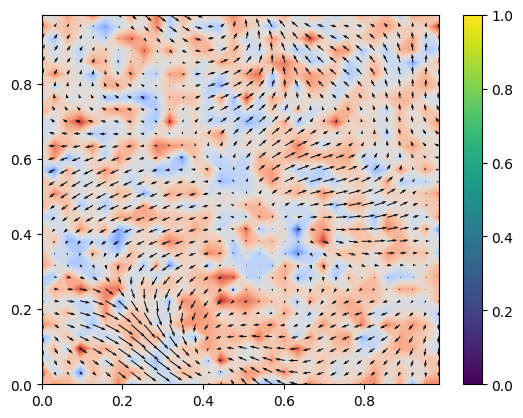

In [7]:
# Define our x and y grid, and the velocities u and v in the x and y directions respectively, and pressure.  
x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

X, Y = np.meshgrid(x, y)

p_prev = np.random.normal(loc=10, size= X.shape)


# We currently model with force as 0, but this can be changed by adding extra terms below.
force_x = np.zeros_like(X)
force_y = np.zeros_like(X)

u_prev, v_prev = k2g_fft(field*0, field, dx=1, pad=False)

#This produces the plot of the initial conditions.
plt.figure()
plt.contourf(X[::2, ::2], Y[::2, ::2], p_prev[::2, ::2], 100, cmap="coolwarm")
plt.quiver(X[::2, ::2], Y[::2, ::2], u_prev[::2, ::2], v_prev[::2, ::2], color="black")
plt.colorbar()
plt.show()


In [8]:
# Define our derivatives in each direction, plus the Laplacian:
# d_dx at f(0,0) is essentially [ f(1,0) - f(-1,0) ] / element_length, since element length is the distance between points, and d_dy is identical. 
# This is a central difference derivative estimate. 
# Since we are wrapping around at the boundaries, this makes calculations easier later. 

# Note that we use the second position as the x coordinate and the first as the y as it is a matrix, so column comes before row. 
def d_dx(f):
  diff = np.zeros_like(f)
  # Boundary conditions for wrap around:
  diff[:, 0] = (f[:, 1] - f[:, -1]) / ( 2 * element_length)   #LHS
  diff[:, -1] = (f[:, 0] - f[:, -2]) / ( 2 * element_length)   #RHS

  #Interior points
  diff[:, 1:-1] = (f[:, 2:  ] - f[:, 0:-2] ) / ( 2 * element_length)

  return diff

def d_dy(f):
  diff = np.zeros_like(f)
  # Boundary conditions for wrap around:
  diff[0, :] = (f[1, :] - f[-1, :]) / ( 2 * element_length)   #TOP
  diff[-1, :] = (f[0, :] - f[-2, :]) / ( 2 * element_length)   #BOTTOM

  #Interior points
  diff[1:-1, :] = (f[2:, :  ] - f[0:-2, :] ) / ( 2 * element_length)

  return diff

def d2_dx2(f):
  diff = np.zeros_like(f)
  # Boundary conditions for wrap around:
  diff[:, 0] = (f[:, 1] - 2 * f[:, 0] + f[:, -1]) / (element_length**2)   #LHS
  diff[:, -1] = (f[:, 0] - 2 * f[:, -1] + f[:, -2]) / (element_length**2)   #RHS

  #Interior points
  diff[:, 1:-1] = (f[:, 2:  ] - 2 * f[:, 1:-1] + f[:, 0:-2] ) / (element_length**2)

  return diff

def d2_dy2(f):
  diff = np.zeros_like(f)
  # Boundary conditions for wrap around:
  diff[0, :] = (f[1, :] - 2 * f[0, :] + f[-1, :]) / ( 2 * element_length)   #TOP
  diff[-1, :] = (f[0, :] - 2 * f[-1, :] + f[-2, :]) / ( 2 * element_length)   #BOTTOM

  #Interior points
  diff[1:-1, :] = (f[2:, :  ] - 2 * f[1:-1, :] + f[0:-2, :] ) / ( 2 * element_length)

  return diff


def laplacian(f):
  # return d_dx(d_dx(u)) + d_dy(d_dy(v)) This is a bad estimate. 
  return d2_dx2(f) + d2_dy2(f) 
  

Our intermediate velocity is: $$ \textbf{u}^* = \textbf{u}^n  - dt (\textbf{u}^n \cdot \nabla  ) \textbf{u}^n + dt \, \nu \nabla^2 \textbf{u}^n $$
Writing this out in terms of our individual components $u$ and $v,$ we get:
$$ \begin{align} u^* & = u - dt \left( u \frac{\partial u}{\partial x} + v \frac{ \partial u}{\partial y} \right) + dt \, \nu \nabla^2 u \\ v^* & = v - dt \left( u \frac{\partial v}{\partial x} + v \frac{ \partial v}{\partial y} \right) + dt \, \nu \nabla^2 v \end{align} $$

In [9]:
def u_intermediate(u, v):
  return u - dt * (np.multiply(u, d_dx(u)) + np.multiply(v, d_dy(u))) + dt * DENSITY * laplacian(u) + dt * force_x
def v_intermediate(u, v):
  return v - dt * (np.multiply(u, d_dx(v)) + np.multiply(v, d_dy(v))) + dt * DENSITY * laplacian(v) + dt * force_y

### Poisson Equation Solution

Our Poisson Equation is: 
$$ \nabla^2 p^{n+1}  = \frac{\rho}{dt} \nabla \cdot \textbf{u}^*. $$
Also recall that our 5 point estimate for the Laplacian is:
$$ \nabla^2 p(0, 0) = \frac{p(0,-1) + p(0, 1) + p(1, 0) + p(-1, 0) - 4 p(0, 0)}{\epsilon^2} $$
Where $\epsilon$ is element_length. Plugging this into the Poisson equation and rearranging gives:
$$ p(0,0) = \frac{1}{4} \left(p(0,-1) + p(0, 1) + p(1, 0) + p(-1, 0) - \epsilon^2 \frac{\rho}{dt} \nabla \cdot \textbf{u}^*(0, 0) \right) $$ 

Which gives us an estimate for pressure at each point. We can use a reccursive process to find this more accurately each time. 

In [10]:
def p_update(u, v, p_prev):
  # Define the right hand side of the poisson equation. 
  rhs = DENSITY / dt * (d_dx(u) + d_dy(v))

  # Iterate and correct. 
  for i in range(N_PRESSURE_POISSON_ITERATIONS):
    p_next = np.zeros_like(p_prev)

    # First add all of the previous pressure terms.
    p_next[:, 0] = p_next[:, 0] + p_prev[:, 1] + p_prev[:, -1]         #LHS
    p_next[:, -1] = p_next[:, -1] + p_prev[:, 0] + p_prev[:, -2]        #RHS
    p_next[:, 1:-1] = p_next[:, 1:-1] + p_prev[:, 2:  ] + p_prev[:, 0:-2] #Interior horizontal points
    p_next[0, :] = p_next[0, :] + p_prev[1, :] + p_prev[-1, :]         #TOP
    p_next[-1, :] = p_next[-1, :] + p_prev[0, :] + p_prev[-2, :]        #BOTTOM
    p_next[1:-1, :] = p_next[1:-1, :] + p_prev[2:, :  ] + p_prev[0:-2, :] #Interior verticle points.

    #Now subtract the RHS term from all points.
    p_next = p_next - element_length**2 * rhs

    #Finally, divide by 4.
    p_next = 0.25 * p_next

    p_prev = p_next

    

  return p_prev



### Final velocity update
Now we need to add our final velocity updating term. 
$$ \textbf{u}^{n+1} = \textbf{u}^* - \frac{dt}{\rho} \nabla p^{n+1} $$
This is straightforward.

In [11]:
def u_update(u, p):
  return (u - dt / DENSITY * d_dx(p))

def v_update(v, p):
  return (v - dt / DENSITY * d_dy(p))

We have now made all of our required functions. We can thus make the iterated process:

In [12]:
for i in range(N_ITERATIONS):
  u_i = u_intermediate(u_prev, v_prev)
  v_i = v_intermediate(u_prev, v_prev)

  p_prev = p_update(u_i, v_i, p_prev)

  u_prev = u_update(u_i, p_prev)
  v_prev = v_update(v_i, p_prev) 

  # Uncomment this to check if it stays divergence free.
  """
  if np.all(d_dx(u_prev) + d_dy(v_prev) != 0) and i % 10 == 0:
  print(d_dx(u_prev) + d_dy(v_prev)) """

# This creates a gif of the updates, but fills your storage with 100 images.
"""
  if i % 5 == 0:
    plt.figure()
    plt.contourf(X[::2, ::2], Y[::2, ::2], p_prev[::2, ::2], 100, cmap="coolwarm")
    plt.colorbar()

    plt.quiver(X[::2, ::2], Y[::2, ::2], u_prev[::2, ::2], v_prev[::2, ::2])
    
    plt.savefig(f'img_{int(i/5)}.png',
                transparent = False,  
                facecolor = 'white'
               )
    
    plt.close()
    
frames = []
for i in range(int(N_ITERATIONS / 5)):
  image = imageio.v2.imread(f'img_{int(i/5)}.png')
  frames.append(image)

imageio.mimsave('./example.gif', # output gif
                frames,          # array of input frames
                fps = 10)         # optional: frames per second """

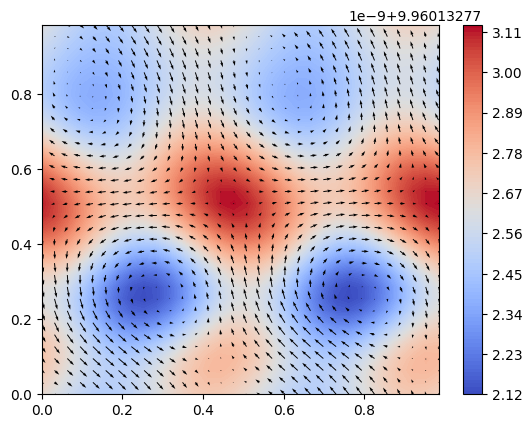

In [13]:
# The [::2, ::2] selects only every second entry (less cluttering plot)
plt.figure()
plt.contourf(X[::2, ::2], Y[::2, ::2], p_prev[::2, ::2], 100, cmap="coolwarm")
plt.colorbar()

plt.quiver(X[::2, ::2], Y[::2, ::2], u_prev[::2, ::2], v_prev[::2, ::2], color="black")
plt.show()

In [14]:
print(p_prev)

[[ 9.96013277 10.01445728  9.96013277 ... 10.01445728  9.96013277
  10.01445728]
 [10.01445728  9.96013277 10.01445728 ...  9.96013277 10.01445728
   9.96013277]
 [ 9.96013277 10.01445728  9.96013277 ... 10.01445728  9.96013277
  10.01445728]
 ...
 [10.01445728  9.96013277 10.01445728 ...  9.96013277 10.01445728
   9.96013277]
 [ 9.96013277 10.01445728  9.96013277 ... 10.01445728  9.96013277
  10.01445728]
 [10.01445728  9.96013277 10.01445728 ...  9.96013277 10.01445728
   9.96013277]]
